# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import csv

# Loading the dataset

In [2]:
chemin = 'ETTh1_without_missing.csv'

# Charger le jeu de données ETTh1 depuis un fichier CSV
df = pd.read_csv(chemin)

print(df.head())

   Id                 date         OT  Unnamed: 3
0   0  2016-07-01 00:00:00  30.531000         NaN
1   1  2016-07-01 01:00:00  27.787001         NaN
2   2  2016-07-01 02:00:00  27.787001         NaN
3   3  2016-07-01 03:00:00  25.044001         NaN
4   4  2016-07-01 04:00:00  21.948000         NaN


In [3]:
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')
df = df[['OT']]
print(df.head())

          OT
0  30.531000
1  27.787001
2  27.787001
3  25.044001
4  21.948000


# Data Analysis

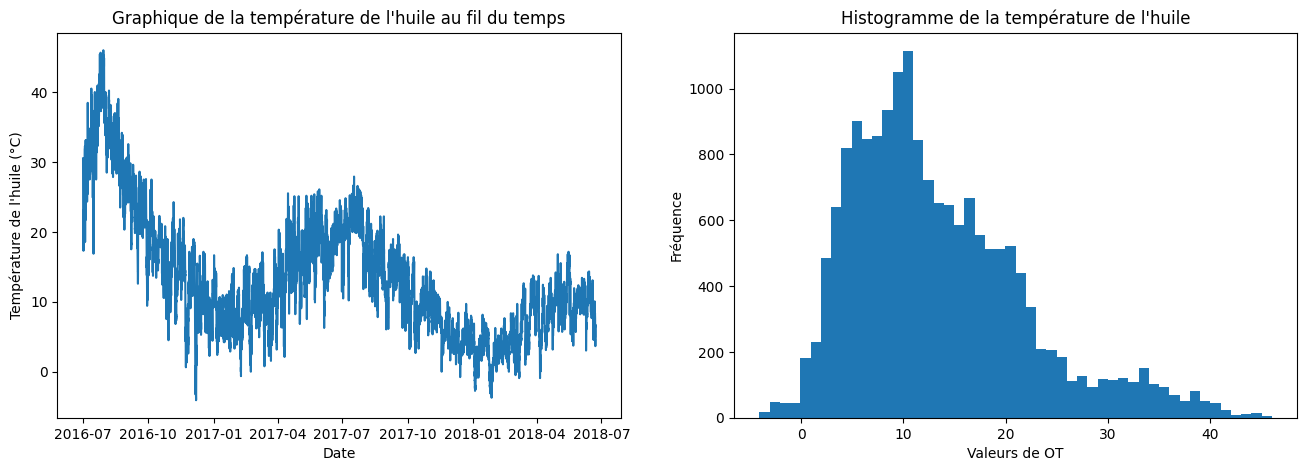

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Tracer le graphique de la température de l'huile au fil du temps
plot_col = df[['OT']]
plot_col.index = date_time
axs[0].plot(plot_col.index, plot_col)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Température de l\'huile (°C)')
axs[0].set_title('Graphique de la température de l\'huile au fil du temps')

# Tracer l'histogramme de la température de l'huile
axs[1].hist(df['OT'], bins=50)
axs[1].set_xlabel('Valeurs de OT')
axs[1].set_ylabel('Fréquence')
axs[1].set_title('Histogramme de la température de l\'huile')

plt.show()

In [5]:
# Donne une idée de la répartition des valeurs
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
OT,17320.0,13.35256,8.582739,-4.08,6.964,11.467,18.15,46.007


# Data splitting

In [6]:
n=len(df)

# Séparation des données en ensemble d'entraînement, de validation et de test
train_df = df[0:int(n*0.7)]  # 70% des données pour l'entraînement
val_df = df[int(n*0.7):int(n*0.9)]  # 20% des données pour la validation
test_df = df[int(n*0.9):]  # 10% des données pour les tests

# Sélection des dernières 1000 lignes du dataframe
last1000_df = df[-1000:]

# Sélection des dernières 1100 lignes du dataframe
last1100_df = df[-1100:]

# Data Normalization

In [7]:
# Calcul de la moyenne et de l'écart type des données d'entraînement
train_mean = train_df.mean()
train_std = train_df.std()

# Normalisation des données d'entraînement, de validation et de test
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
last1000_df = (last1000_df - train_mean) / train_std
last1100_df = (last1100_df - train_mean) / train_std

# Data preparation for training

In [8]:
class SlidingWindowGenerator():

    def __init__(self, input_width, label_width, offset,
                 train, val, test, label_columns=None):
        # Initialisation de l'objet SlidingWindowGenerator avec les paramètres spécifiés
        self.train_data = train  # Données d'entraînement
        self.val_data = val      # Données de validation
        self.test_data = test    # Données de test

        self.label_columns = label_columns  # Colonnes d'étiquettes

        if label_columns is not None:
            # Création d'un dictionnaire des indices des colonnes d'étiquettes
            self.label_columns_indices = {name:i for i, name in enumerate(label_columns)}

        # Création d'un dictionnaire des indices de colonnes
        self.column_indices = {name:i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width    # Largeur d'entrée
        self.label_width = label_width    # Largeur de l'étiquette
        self.offset = offset              # Décalage

        # Longueur totale de la fenêtre
        self.total_window_length = input_width + offset

        # Tranche d'entrée
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_length)[self.input_slice]

        # Début de l'étiquette
        self.label_start = self.total_window_length - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_length)[self.labels_slice]

    def split_window(self, data):
        # Séparation des données en entrées et étiquettes
        inputs = data[:, self.input_slice,:]  # Entrées
        labels = data[:, self.labels_slice, :]  # Étiquettes
        if self.label_columns is not None:
            # Empilement des étiquettes pour les colonnes spécifiées
            labels = tf.stack(
                [labels[:, :,self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        # Création d'un ensemble de données à partir des données spécifiées
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_length,
            sequence_stride=1,
            shuffle=False,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    def plot_mae(self, model, col_name='OT'):
        # Évaluation du modèle sur l'ensemble d'entraînement
        train_mae = model.evaluate(self.train)[0]

        # Évaluation du modèle sur l'ensemble de validation
        val_mae = model.evaluate(self.val)[0]

        # Évaluation du modèle sur l'ensemble de test
        test_mae = model.evaluate(self.test)[0]

        # Affichage des valeurs de MAE
        print(f'MAE d\'entraînement ({col_name}): {train_mae}')
        print(f'MAE de validation ({col_name}): {val_mae}')
        print(f'MAE de test ({col_name}): {test_mae}')

        return train_mae, val_mae, test_mae

    def __str__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_length}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    @property
    def train(self):
        return self.make_dataset(self.train_data)

    @property
    def val(self):
        return self.make_dataset(self.val_data)

    @property
    def test(self):
        return self.make_dataset(self.test_data)

# Model

In [9]:
MAX_EPOCHS = 30

def compile_and_fit(model, window):
    # Définition du callback pour l'arrêt
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    # Entraînement du modèle avec les données d'entraînement et de validation
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


In [10]:
window_ds = SlidingWindowGenerator(input_width=1000, label_width=150, offset=100, train=train_df, val=val_df, test=test_df, label_columns=['OT'])

print(window_ds)

Total window size: 1100
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

In [11]:
for input, label in window_ds.test.take(1):
    input_x = input
    label_y = label
    print('Input Shape:', input.shape)
    print('Output Shape:', label.shape)

Input Shape: (32, 1000, 1)
Output Shape: (32, 150, 1)


In [12]:
# cnn_model = keras.Sequential(
#     [
#         #tester avec , kernel_regularizer=regularizers.l2(0.1) pour le dense
#         keras.Input(shape=(1000,1)),
#         layers.Conv1D(filters=64, kernel_size=(10,),activation='relu'),
#         layers.Dense(units=64, activation='relu'),
#         layers.Dropout(0.2),
#         layers.Flatten(),
#         layers.Dense(units=150)
#     ]
# )

# LSTM offre de meilleurs résultats
lstm_model = keras.Sequential(
    [
        keras.Input(shape=(1000, 1)),
        layers.LSTM(units=256, return_sequences=True),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(units=150)
    ]
)

model = lstm_model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 256)         264192    
                                                                 
 dropout (Dropout)           (None, 1000, 256)         0         
                                                                 
 flatten (Flatten)           (None, 256000)            0         
                                                                 
 dense (Dense)               (None, 150)               38400150  
                                                                 
Total params: 38,664,342
Trainable params: 38,664,342
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = compile_and_fit(model, window_ds)

Epoch 1/30
345/345 [==============================] - 43s 117ms/step - loss: 0.2159 - mean_absolute_error: 0.3432 - val_loss: 0.1946 - val_mean_absolute_error: 0.3349
Epoch 2/30
345/345 [==============================] - 41s 119ms/step - loss: 0.1795 - mean_absolute_error: 0.3142 - val_loss: 0.1547 - val_mean_absolute_error: 0.3132
Epoch 3/30
345/345 [==============================] - 41s 119ms/step - loss: 0.1582 - mean_absolute_error: 0.2915 - val_loss: 0.1193 - val_mean_absolute_error: 0.2493
Epoch 4/30
345/345 [==============================] - 41s 120ms/step - loss: 0.1467 - mean_absolute_error: 0.2741 - val_loss: 0.0887 - val_mean_absolute_error: 0.2121
Epoch 5/30
345/345 [==============================] - 41s 118ms/step - loss: 0.1400 - mean_absolute_error: 0.2672 - val_loss: 0.0864 - val_mean_absolute_error: 0.2080
Epoch 6/30
345/345 [==============================] - 41s 118ms/step - loss: 0.1379 - mean_absolute_error: 0.2659 - val_loss: 0.0819 - val_mean_absolute_error: 0.203

# SAVE & LOAD

In [14]:
# # Sauvegarder le modèle complet au format HDF5
#model.save('modelDS/model123.h5')

In [15]:
# # Charger le modèle complet
# from keras.models import load_model
# model = load_model('modelDS/model56.h5')

# model.summary()

# Graphes + predictions + csv

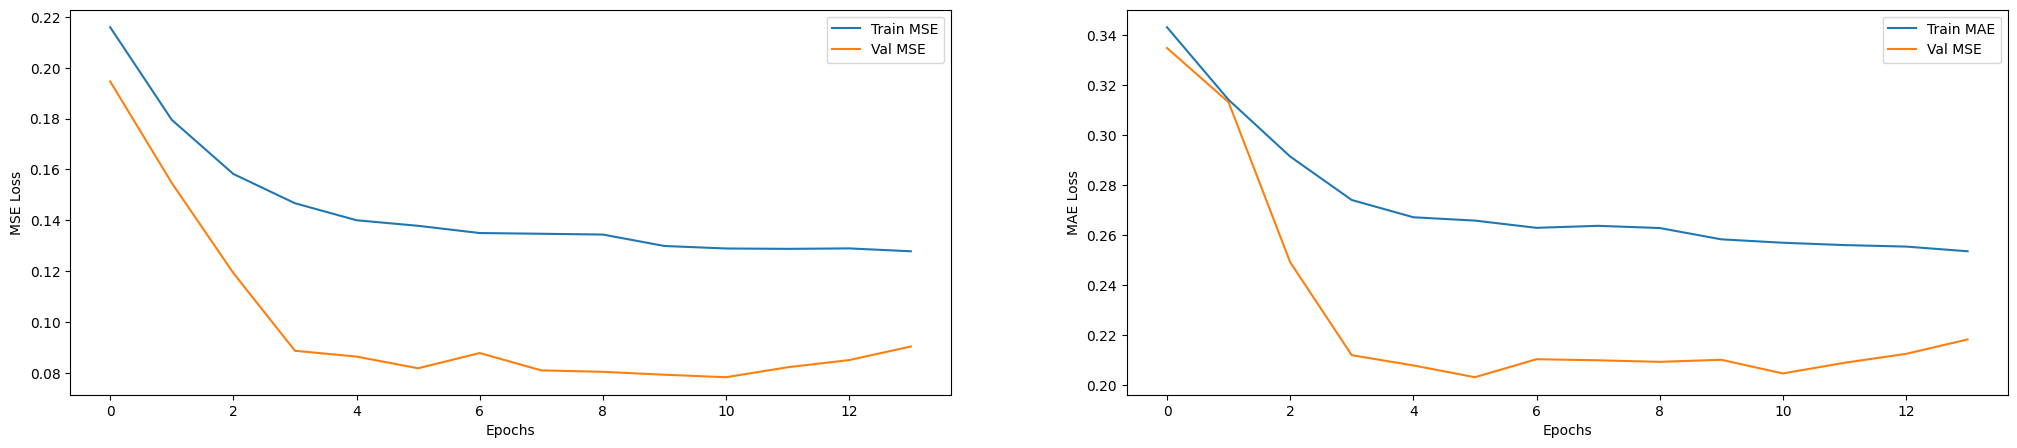

In [16]:
fig, axs = plt.subplots(1,2, figsize=(25,5))
metrics = list(history.history.keys())

axs[0].plot(history.history['loss'], label='Train MSE')
axs[0].plot(history.history['val_loss'], label='Val MSE')
axs[0].set_ylabel('MSE Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Val MSE')
axs[1].set_ylabel('MAE Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()
plt.show()

In [17]:
model.evaluate(window_ds.test)

20/20 [==============================] - 1s 41ms/step - loss: 0.0193 - mean_absolute_error: 0.0972


[0.01932637207210064, 0.09715459495782852]

## Predictions

In [18]:
new_data = {"OT": [0] * 100}

# Créer un DataFrame à partir de la nouvelle série de données
new_df = pd.DataFrame(new_data)

# Concaténer le nouveau DataFrame avec l'ancien
combined_df = pd.concat([last1000_df, new_df], ignore_index=True)

last1000_ds = window_ds.make_dataset(combined_df)

In [20]:
# Prendre uniquement le premier élément de last1000_ds
input_x, label_y = next(iter(last1000_ds))

# Faire des prédictions avec le modèle
predictions = model.predict(input_x)
predictions = [item for sublist in predictions for item in sublist]

# Création d'un DataFrame avec les prédictions
df_pred = pd.DataFrame({'OT': predictions})

# Dénormalisation des prédictions
df_pred = df_pred * train_std + train_mean
predictions = df_pred['OT'].values


1/1 [==============================] - 0s 316ms/step


## CSV

In [21]:
# Combinaison des données 'OT' avec les prédictions
predictions_with_header = [['Id','OT']]
for i, prediction in enumerate(predictions[50:]):
    predictions_with_header.append([i,prediction])

# Écriture dans un fichier CSV
with open('predictionsN30.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(predictions_with_header)

print("Fichier CSV créé avec succès.")

Fichier CSV créé avec succès.


# Test sur les 1100 dernieres valeurs 

In [ ]:
# last1100_ds = window_ds.make_dataset(last1100_df)

# model.evaluate(last1100_ds)

In [ ]:
# input_x, label_y = next(iter(last1100_ds))

# predictions = model.predict(input_x)
# predictions = [item for sublist in predictions for item in sublist]
# df_pred = pd.DataFrame({'OT': predictions})
# df_pred = df_pred * train_std + train_mean

# df_y  = [item for sublist in label_y  for item in sublist]
# df_y = pd.DataFrame({'OT': df_y})
# df_y = df_y * train_std + train_mean
# df_y['OT'] = df_y['OT'].astype(float)

# predictions = df_pred['OT'].values
# true_values = df_y['OT'].values
# mae = mean_absolute_error(true_values, predictions)
# print('Mean Absolute Error:', mae)